## Import and Configure Everything We Need

In [1]:
from collections import defaultdict as ddict, OrderedDict as odict
from typing import Any, Dict, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from rdkit.Chem import PandasTools, AllChem as Chem, Descriptors
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.model_selection import KFold
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

__author__ = 'Marcel Baltruschat'
__copyright__ = 'Copyright © 2020-2023'
__license__ = 'MIT'
__version__ = '1.1.0'
__additional__ = 'Changes & adaptions by Alexander Minidis'

pd.set_option('display.float_format', lambda x: '%.3f' % x)  # Display floats without scientific notation
sns.set(palette='bright')  # Set bright style for Seaborn
PandasTools.RenderImagesInAllDataFrames()  # Render mol images

# In many cases NaN
not_used_desc = [
    'HeavyAtomMolWt',
    "ExactMolWt",
    "FpDensityMorgan1",
    "FpDensitymorgan",
    "FpDensitymorgan",
    'MaxPartialCharge', 
    'MinPartialCharge',
    'MaxAbsPartialCharge', 
    'MinAbsPartialCharge', 
    'BCUT2D_MWHI',
    'BCUT2D_MWLOW',
    'BCUT2D_CHGHI',
    'BCUT2D_CHGLO',
    'BCUT2D_LOGPHI',
    'BCUT2D_LOGPLOW',
    'BCUT2D_MRHI',
    'BCUT2D_MRLOW',
]

# Create a descriptor calculator for all RDKit descriptors except the ones above
desc_calc = MolecularDescriptorCalculator([x for x in [x[0] for x in Descriptors.descList] if x not in not_used_desc])
print(f'Number of descriptors used: {len(desc_calc.descriptorNames)}/{len(Descriptors.descList)}')

Number of descriptors used: 193/208


## Defining Cross-Validation Class

In [2]:
"""
Copyright © 2019 Marcel Baltruschat

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files 
(the “Software”), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, 
publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do 
so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

Source: https://github.com/czodrowskilab/gafp/tree/master/fp
"""
class CVRegressor:
    """
    Regressor that predicts based on predictions of k models from k-fold CV.
    Accepts any Scikit-learn-like regressor as base regressor. It trains k models
    by doing k-fold CV and stores the individual models. Predictions
    on new samples are done by calculating mean predictions from all models.
    
    Parameters
    ----------
    est : Any
        Scikit-learn (-like) regressor object. Must contain .fit() and .predict() methods.
    params : Dict[str, Any]
        Regressor parameters
    n_folds : int
        Number of folds for k-fold
    shuffle : bool
        Shuffling of data for CV
    """
    __slots__ = ('est', 'params', 'models', 'n_folds', 'shuffle', 'cv_scores')

    def __init__(self, est: Any, params: Dict[str, Any], n_folds: int = 5, shuffle: bool = True):
        self.est = est
        self.params = params
        self.models = []
        self.n_folds = n_folds
        self.shuffle = shuffle
        self.cv_scores = ddict(list)

    def fit(self, x_data: np.ndarray, y_data: np.ndarray, scoring_funcs: List=(), random_state: int=None) -> None:
        """
        Build a regressor consisting of k-models.
        
        Parameters
        ----------
        x_data : numpy.ndarray
            Training data
        y_data : numpy.ndarray
            Target values
        scoring_funcs : list
            List of scoring functions to use for evaluating cross-validation results
        random_state : int
            Integer to use for seeding the k-fold split
        """

        kf = KFold(n_splits=self.n_folds, shuffle=self.shuffle, random_state=random_state)
        kf = kf.split(X=x_data, y=y_data)

        # Fit k models and store them
        for train_index, test_index in kf:
            est_tmp = self.est(**self.params)
            est_tmp.fit(x_data[train_index], y_data[train_index])
            if scoring_funcs:
                test_pred = est_tmp.predict(x_data[test_index])
                for sf in scoring_funcs:
                    self.cv_scores[str(sf).split(' ')[1]].append(sf(y_data[test_index], test_pred))
            self.models.append(est_tmp)

    def predict(self, x_data: np.ndarray) -> np.ndarray:
        """
        Predict using prediction mean from k models.
        
        Parameters
        ----------
        x_data : numpy.ndarray
            Samples to predict
        
        Returns
        -------
        numpy.ndarray
            Predicted values
        """

        return np.mean([m.predict(x_data) for m in self.models], axis=0)

## Defining Helpful Functions

In [3]:
def rmse(y_true, y_pred):
    """Helper function"""
    return mean_squared_error(y_true, y_pred, squared=False)

def calc_stats_str(pka1, pka2):
    """Calculates R², MAE and RMSE for two iterables of floats or integers"""
    assert len(pka1) == len(pka2), "Both iterables must have the same length"
    return f'R²: {r2_score(pka1, pka2):.3f}\n' \
           f'MAE: {mean_absolute_error(pka1, pka2):.3f}\n' \
           f'RMSE: {rmse(pka1, pka2):.3f}'

def train_cv_model(est_cls, x_data, y_data, params, random_state,
                   cv=5, shuffle=True, scaled=False, scoring_funcs=(mean_absolute_error, rmse, r2_score)):
    """Scales the training data if wanted and trains a cross-validated model"""
    scaler = None
    if scaled:
        scaler = StandardScaler()
        x_data = scaler.fit_transform(x_data)
    cvr = CVRegressor(est=est_cls, params=params, n_folds=cv, shuffle=shuffle)
    cvr.fit(x_data, y_data, scoring_funcs=scoring_funcs, random_state=random_state)
    return cvr, scaler

def calc_x_data(mols, radius=3, nBits=2048):  
    """Calculates descriptors and fingerprints for an iterable of RDKit molecules"""
    descs = []
    fmorgan = [] 
    for mol in mols:
        descs.append(desc_calc.CalcDescriptors(mol))
        fmorgan.append(Chem.GetMorganFingerprintAsBitVect(mol, radius=radius, nBits=nBits, useFeatures=True))
    descs = np.array(descs)
    fmorgan = np.array(fmorgan)
    return descs, fmorgan, np.concatenate([descs, fmorgan], axis=1)

---
## Loading Precombined Dataset

Initial: 5921


pKa  marvin_pKa  marvin_atom marvin_pKa_type original_dataset  \
ID                                                                       
273537 7.460       8.200            8           basic     ['chembl25']   
7175   4.200       3.940            7           basic  ['datawarrior']   

                                                   ROMol  
ID                                                        
273537  <rdkit.Chem.rdchem.Mol object at 0x7f9279c6daf0>  
7175    <rdkit.Chem.rdchem.Mol object at 0x7f9279c6db60>
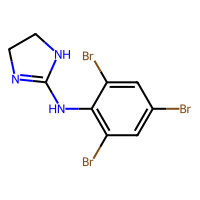
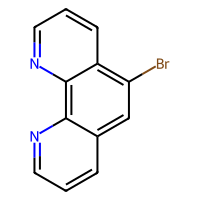

In [4]:
sdf_path = './datasets/combined_training_datasets_unique_no_oe.sdf'
all_df = PandasTools.LoadSDF(sdf_path).astype(dict(pKa=float, 
                                                   marvin_atom=int, 
                                                   marvin_pKa=float), 
                                              copy=False).set_index('ID', verify_integrity=True)
print(f'Initial: {len(all_df)}')
all_df.head(2)

## Show p<i>K</i><sub>a</sub> Distribution

In [5]:
sns_major, sns_minor = map(int, sns.__version__.split('.')[:2])

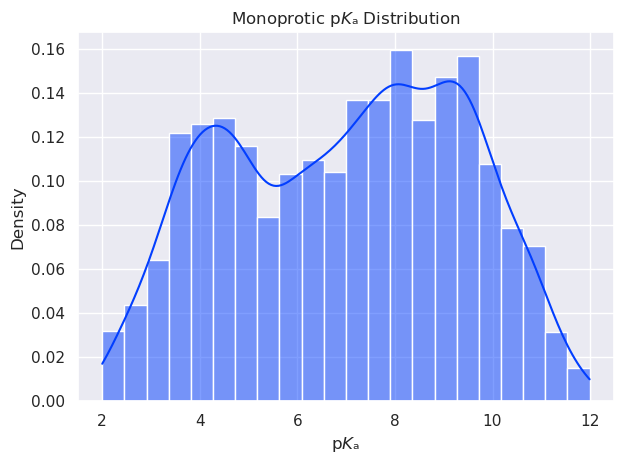

In [6]:
plt.figure(dpi=100)
if sns_major > 0 or sns_minor >= 11:
    sns.histplot(all_df.pKa, kde=True, stat='density')
else:
    sns.distplot(all_df.pKa)
plt.ylabel('Density')
plt.xlabel('p$K$ₐ')
plt.title('Monoprotic p$K$ₐ Distribution')
plt.tight_layout()
plt.show()

## Calculating Descriptors and Fingerprints
- Selected RDKit descriptors (see first notebook cell)
- Morgan FP with radius=3 and useFeatures=True (Fmorgan)

In [7]:
descs, fmorgan, descs_fmorgan = calc_x_data(all_df.ROMol, radius=3, nBits=2048)

Traceback (most recent call last):
  File "/home/alex/anaconda3/envs/py311/lib/python3.11/site-packages/rdkit/ML/Descriptors/MoleculeDescriptors.py", line 88, in CalcDescriptors
    res[i] = fn(mol)
             ^^^^^^^
  File "/home/alex/anaconda3/envs/py311/lib/python3.11/site-packages/rdkit/Chem/GraphDescriptors.py", line 124, in Ipc
    cPoly = abs(Graphs.CharacteristicPolynomial(mol, adjMat))
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/alex/anaconda3/envs/py311/lib/python3.11/site-packages/rdkit/Chem/Graphs.py", line 43, in CharacteristicPolynomial
    res = numpy.zeros(nAtoms + 1, numpy.float)
                                  ^^^^^^^^^^^
  File "/home/alex/anaconda3/envs/py311/lib/python3.11/site-packages/numpy/__init__.py", line 324, in __getattr__
    raise AttributeError(__former_attrs__[attr])
AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code,

---
## Training Random Forest
#### Using the following training sets with 5-fold cross-validation (shuffled)
1. RDKit descriptor set
2. Fmorgan
3. RDKit descriptor set + Fmorgan
4. RDKit descriptor set (standard scaled)
5. Fmorgan (standard scaled)
6. RDKit descriptor set + Fmorgan (standard scaled)

### Prepare for Training

In [8]:
seed = 42

est_jobs = -1
verbose = False

y_train = all_df.pKa.values
desc_sets = list(zip([descs, fmorgan, descs_fmorgan] * 2, 
                     [False] * 3 + [True] * 3, 
                     ['Desc', 'FMorgan', 'Desc_FMorgan', 'Desc_scaled', 'FMorgan_scaled', 'Desc_FMorgan_scaled']))

models = ddict(odict)  # estimator => training set => [model, scaler]

def train_all_sets(est_cls, params, name):
    for x_data, scaled, set_name in desc_sets:
        models[name][set_name] = train_cv_model(est_cls, x_data, y_train, params, seed, scaled=scaled)

In [9]:
def generate_score_board(name):
    print(f'{name} CV Scores:')
    for ts, (m, s) in models[name].items():
        print(f'\t{ts}')
        for k, v in m.cv_scores.items():
            print(f'\t\t- {k}: {np.mean(v):.3f} ± {np.std(v):.3f}')

---
### RandomForest (n_estimators=1000)

In [10]:
est_cls = RandomForestRegressor
rf_params = dict(n_estimators=1000, n_jobs=est_jobs, verbose=verbose, random_state=seed)
name = 'RandomForest (n_estimators=1000)'

train_all_sets(est_cls, rf_params, name)

#### CV Scores

In [11]:
generate_score_board(name)

RandomForest (n_estimators=1000) CV Scores:
	Desc
		- mean_absolute_error: 0.758 ± 0.026
		- rmse: 1.144 ± 0.041
		- r2_score: 0.772 ± 0.017
	FMorgan
		- mean_absolute_error: 0.790 ± 0.033
		- rmse: 1.213 ± 0.048
		- r2_score: 0.744 ± 0.016
	Desc_FMorgan
		- mean_absolute_error: 0.733 ± 0.023
		- rmse: 1.116 ± 0.031
		- r2_score: 0.784 ± 0.011
	Desc_scaled
		- mean_absolute_error: 0.758 ± 0.026
		- rmse: 1.145 ± 0.042
		- r2_score: 0.772 ± 0.017
	FMorgan_scaled
		- mean_absolute_error: 0.790 ± 0.033
		- rmse: 1.213 ± 0.048
		- r2_score: 0.744 ± 0.016
	Desc_FMorgan_scaled
		- mean_absolute_error: 0.733 ± 0.023
		- rmse: 1.116 ± 0.030
		- r2_score: 0.784 ± 0.011


---
### RandomForest (n_estimators=500)

In [12]:
est_cls = RandomForestRegressor
rf_params = dict(n_estimators=500, n_jobs=est_jobs, verbose=verbose, random_state=seed)
name = 'RandomForest (n_estimators=500)'

train_all_sets(est_cls, rf_params, name)

In [20]:
generate_score_board(name)

RandomForest (n_estimators=500) CV Scores:
	Desc
		- mean_absolute_error: 0.758 ± 0.026
		- rmse: 1.144 ± 0.041
		- r2_score: 0.772 ± 0.017
	FMorgan
		- mean_absolute_error: 0.791 ± 0.033
		- rmse: 1.214 ± 0.048
		- r2_score: 0.744 ± 0.016
	Desc_FMorgan
		- mean_absolute_error: 0.733 ± 0.024
		- rmse: 1.116 ± 0.031
		- r2_score: 0.783 ± 0.011
	Desc_scaled
		- mean_absolute_error: 0.758 ± 0.026
		- rmse: 1.145 ± 0.042
		- r2_score: 0.772 ± 0.017
	FMorgan_scaled
		- mean_absolute_error: 0.791 ± 0.033
		- rmse: 1.214 ± 0.048
		- r2_score: 0.744 ± 0.016
	Desc_FMorgan_scaled
		- mean_absolute_error: 0.733 ± 0.023
		- rmse: 1.116 ± 0.030
		- r2_score: 0.783 ± 0.011


---
## Predicting external testsets

In [13]:
novartis_testset = PandasTools.LoadSDF('./datasets/novartis_cleaned_mono_unique_notraindata.sdf').set_index('ID', verify_integrity=True)
avlilumove_testset = PandasTools.LoadSDF('./datasets/AvLiLuMoVe_cleaned_mono_unique_notraindata.sdf').set_index('ID', verify_integrity=True)
len(novartis_testset), len(avlilumove_testset)

(280, 123)

#### Calculating descriptors

In [14]:
descs_nov, fmorgan_nov, descs_fmorgan_nov = calc_x_data(novartis_testset.ROMol)
descs_avl, fmorgan_avl, descs_fmorgan_avl = calc_x_data(avlilumove_testset.ROMol)

Traceback (most recent call last):
  File "/home/alex/anaconda3/envs/py311/lib/python3.11/site-packages/rdkit/ML/Descriptors/MoleculeDescriptors.py", line 88, in CalcDescriptors
    res[i] = fn(mol)
             ^^^^^^^
  File "/home/alex/anaconda3/envs/py311/lib/python3.11/site-packages/rdkit/Chem/GraphDescriptors.py", line 124, in Ipc
    cPoly = abs(Graphs.CharacteristicPolynomial(mol, adjMat))
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/alex/anaconda3/envs/py311/lib/python3.11/site-packages/rdkit/Chem/Graphs.py", line 43, in CharacteristicPolynomial
    res = numpy.zeros(nAtoms + 1, numpy.float)
                                  ^^^^^^^^^^^
  File "/home/alex/anaconda3/envs/py311/lib/python3.11/site-packages/numpy/__init__.py", line 324, in __getattr__
    raise AttributeError(__former_attrs__[attr])
AttributeError: module 'numpy' has no attribute 'float'.
`np.float` was a deprecated alias for the builtin `float`. To avoid this error in existing code,

#### Predicting with all models

In [15]:
def test_all_models(desc, fp, both, true_vals):
    res = ddict(list)
    for conf, desc_set in models.items():
        for ts, (m, s) in desc_set.items():
            
            x_test = both if ts.startswith('Desc_FMorgan') else fp if ts.startswith('FMorgan') else desc
            if s:
                x_test = s.transform(x_test)
            pred = m.predict(x_test)
            res['Model'].append(conf)
            res['Trainset'].append(ts)
            res['MAE'].append(mean_absolute_error(true_vals, pred))
            res['RMSE'].append(rmse(true_vals, pred))
            res['R2'].append(r2_score(true_vals, pred))
    return pd.DataFrame(res)

In [16]:
res_df_nov = test_all_models(descs_nov, fmorgan_nov, descs_fmorgan_nov, novartis_testset.pKa)

In [17]:
res_df_nov

Model             Trainset   MAE  RMSE     R2
0   RandomForest (n_estimators=1000)                 Desc 1.717 2.092  0.175
1   RandomForest (n_estimators=1000)              FMorgan 1.792 2.208  0.081
2   RandomForest (n_estimators=1000)         Desc_FMorgan 2.005 2.362 -0.052
3   RandomForest (n_estimators=1000)          Desc_scaled 1.717 2.091  0.176
4   RandomForest (n_estimators=1000)       FMorgan_scaled 1.792 2.208  0.081
5   RandomForest (n_estimators=1000)  Desc_FMorgan_scaled 2.007 2.364 -0.053
6    RandomForest (n_estimators=500)                 Desc 1.718 2.092  0.175
7    RandomForest (n_estimators=500)              FMorgan 1.794 2.212  0.078
8    RandomForest (n_estimators=500)         Desc_FMorgan 2.000 2.356 -0.046
9    RandomForest (n_estimators=500)          Desc_scaled 1.718 2.092  0.175
10   RandomForest (n_estimators=500)       FMorgan_scaled 1.794 2.212  0.078
11   RandomForest (n_estimators=500)  Desc_FMorgan_scaled 2.003 2.359 -0.049

In [18]:
res_df_avl = test_all_models(descs_avl, fmorgan_avl, descs_fmorgan_avl, avlilumove_testset.pKa)

In [19]:
res_df_avl

Model             Trainset   MAE  RMSE    R2
0   RandomForest (n_estimators=1000)                 Desc 1.174 1.498 0.597
1   RandomForest (n_estimators=1000)              FMorgan 1.639 2.236 0.102
2   RandomForest (n_estimators=1000)         Desc_FMorgan 1.670 2.173 0.151
3   RandomForest (n_estimators=1000)          Desc_scaled 1.174 1.497 0.597
4   RandomForest (n_estimators=1000)       FMorgan_scaled 1.639 2.236 0.102
5   RandomForest (n_estimators=1000)  Desc_FMorgan_scaled 1.669 2.172 0.153
6    RandomForest (n_estimators=500)                 Desc 1.166 1.490 0.601
7    RandomForest (n_estimators=500)              FMorgan 1.647 2.243 0.096
8    RandomForest (n_estimators=500)         Desc_FMorgan 1.671 2.170 0.154
9    RandomForest (n_estimators=500)          Desc_scaled 1.166 1.489 0.602
10   RandomForest (n_estimators=500)       FMorgan_scaled 1.647 2.243 0.096
11   RandomForest (n_estimators=500)  Desc_FMorgan_scaled 1.670 2.170 0.154